In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import scipy

import scipy.stats as stats
import pylab as pl

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# loanamount = float(input("Enter your loan amount? "))
loanamount = 250000

In [3]:
data1=pd.read_csv('./datasets/home_loans_history_2018-01-05_1.csv',sep=',')

In [4]:
data1.shape

(4329, 107)

In [5]:
data2= pd.read_csv('./datasets/new_flex_score.csv', sep=',')

In [6]:
data2.columns

Index(['Company Name + Variation Name', 'Avg. costscore uncapped',
       'flexscore shortlist'],
      dtype='object')

In [7]:
data2.shape


(4328, 3)

In [8]:
max(data2['Avg. costscore uncapped']), min(data2['Avg. costscore uncapped'])

(5.5, -7.7239500000000003)

In [9]:
def func_a(row):
    if row['Avg. costscore uncapped'] < 1:
        return 1
    elif row['Avg. costscore uncapped'] > 5 :
        return 5 
    else:
        return row['Avg. costscore uncapped']
data2['new_cost_score']= data2.apply(func_a , axis=1)

In [10]:
data2['total_score']= (0.7*data2['new_cost_score'])+(0.3*data2['flexscore shortlist'])

In [11]:
data2=data2[['Company Name + Variation Name','total_score']]

In [12]:
data1["Company Name + Variation Name"] = data1["companyname"].map(str) + ' ' + '-' + ' '+data1["variationname"]

In [13]:
data1['Intial Repayment']=np.where((data1['hasintroductoryrate']== False),(loanamount/((1-(1+(data1['rate']/1200))**(-360))/((data1['rate']/1200))))
            ,([loanamount]/((1-(1+(data1['introductoryrate']/1200))**(-360))/((data1['introductoryrate']/1200)))))

In [14]:
def func(row):
    if row['homeloantype']=='FIXED':
        return row['Intial Repayment']*((1-(1+(row['rate']/1200))**(-(360-row['fixmonth'])))/((row['rate']/1200)))
    elif ((row['hasintroductoryrate'] == True ) & (row['homeloantype']=='VARIABLE')):
        return row['Intial Repayment']*((1-(1+(row['introductoryrate']/1200))**(-(360-row['introductoryterm'])))/((row['introductoryrate']/1200))) 
    else:
        return ''

data1['Balance Outstanding'] = data1.apply(func, axis=1)

In [15]:
def func_2(row):
    if (row['homeloantype']=='FIXED'):
        return row['Intial Repayment']*row['fixmonth'] + (row['Balance Outstanding']/((1-(1+(row['revertrate']/1200))**(-(360-row['fixmonth'])))/((row['revertrate']/1200))))*(60-row['fixmonth'])
    elif ((row['hasintroductoryrate'] == True ) & (row['homeloantype']=='VARIABLE')):
        return row['Intial Repayment']*row['introductoryterm'] + (row['Balance Outstanding']/((1-(1+(row['rate']/1200))**(-(360-row['introductoryterm'])))/((row['rate']/1200))))*(60-row['introductoryterm'])
    else:
        return row['Intial Repayment']*60
    
data1['Total Repayment']=data1.apply(func_2,axis=1)

In [16]:
def func_3(row):
    if ((row['monthlyfees']>0.0)&(row['annualfees'] == 0)):
        return ((row['monthlyfees']*60)+row['upfrontfee']+row['dischargefee'])
    elif ((row['monthlyfees']==0.0)&(row['annualfees'] > 0)):
        return ((row['annualfees']*5)+row['upfrontfee']+row['dischargefee'])
    elif ((row['monthlyfees']==0.0)&(row['annualfees'] == 0)):
        return (row['upfrontfee']+row['dischargefee'])

data1['Fees']=data1.apply(func_3,axis=1)  

In [17]:
data1['Total Cost']= data1['Total Repayment']+data1['Fees']

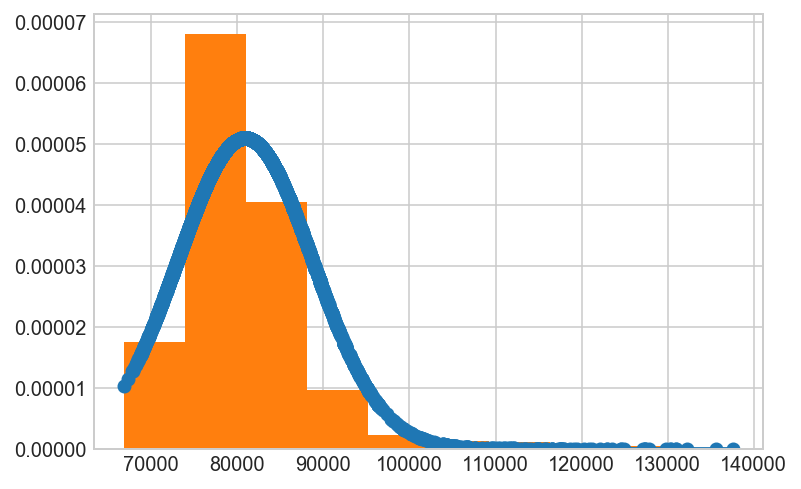

In [18]:
c = sorted(data1['Total Cost'])  #sorted

fit = stats.norm.pdf(c, np.mean(c), np.std(c))  #this is a fitting indeed

pl.plot(c,fit,'-o')

pl.hist(c,normed=True)      #use this to draw histogram of your data

pl.show() 

In [19]:
data1['cost score']=[(((max(data1['Total Cost'])- x)/(max(data1['Total Cost'])-min(data1['Total Cost'])))*4)+1 for x in data1['Total Cost'] ]

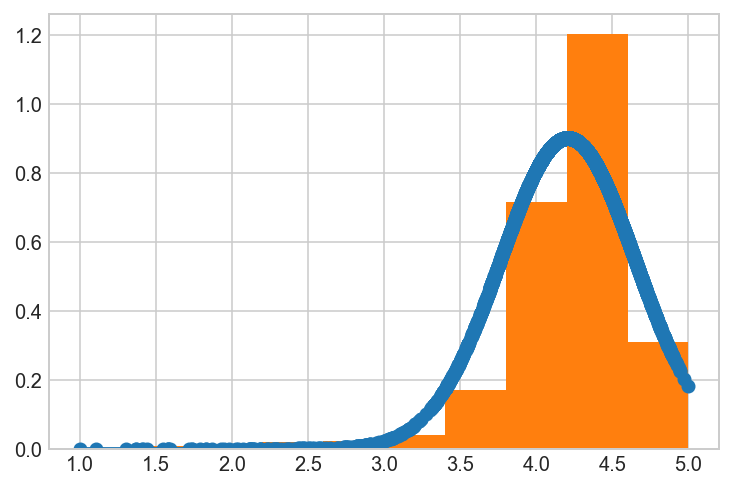

In [20]:
h = sorted(data1['cost score'])  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show() 

In [21]:
len(data1[(data1['cost score'] >= 3.75) & (data1['cost score'] < 4.25)])/len(data1['cost score']) * 100


36.45183645183645

In [22]:
max(data1['cost score']) , min(data1['cost score'])

(5.0, 1.0)

In [23]:
df=pd.DataFrame({'cost score':data1['cost score'], 'boxcox' : scipy.stats.boxcox(data1['cost score'], lmbda=None, alpha=None)[0] ,
                "Company Name + Variation Name":data1["Company Name + Variation Name"]})

In [24]:
df.shape

(4329, 3)

In [25]:
data1.shape

(4329, 114)

In [26]:
data=pd.merge(data1,df,how='left',on=['Company Name + Variation Name','cost score']).drop_duplicates(subset=None, keep='first', inplace=False)


In [27]:
data.shape

(4329, 115)

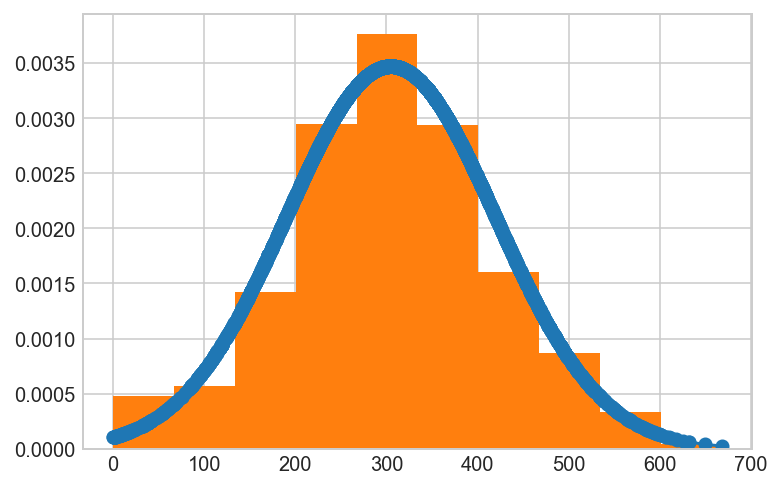

In [28]:
h = sorted(data['boxcox'])  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show()

In [29]:
data['cost score2']=[(((max(data['boxcox'])- x)/(max(data['boxcox'])-min(data['boxcox'])))*5) for x in data['boxcox'] ]





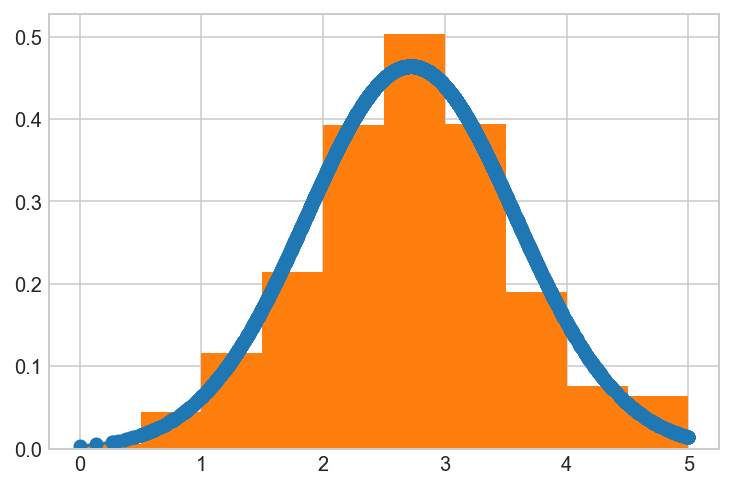

In [30]:
h = sorted(data['cost score2'])  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show()

In [31]:
len(data[(data['cost score2'] >= 0) & (data['cost score2'] < 0.25)])/len(data['cost score2']) * 100

0.046200046200046196

In [32]:
len(data[(data['cost score2'] >= 0.25) & (data['cost score2'] < 0.75)])/len(data['cost score2']) * 100

1.0164010164010164

In [33]:
len(data[(data['cost score2'] >= 0.75) & (data['cost score2'] < 1.25)])/len(data['cost score2']) * 100

3.4419034419034418

In [34]:
len(data[(data['cost score2'] >= 1.25) & (data['cost score2'] < 1.75)])/len(data['cost score2']) * 100

8.57010857010857

In [35]:
len(data[(data['cost score2'] >= 1.75) & (data['cost score2'] < 2.25)])/len(data['cost score2']) * 100

14.73781473781474

In [36]:
len(data[(data['cost score2'] >= 2.25) & (data['cost score2'] < 2.75)])/len(data['cost score2']) * 100

23.515823515823516

In [37]:
len(data[(data['cost score2'] >= 2.75) & (data['cost score2'] < 3.25)])/len(data['cost score2']) * 100

24.301224301224302

In [38]:
len(data[(data['cost score2'] >= 3.25) & (data['cost score2'] < 3.75)])/len(data['cost score2']) * 100

13.444213444213442

In [39]:
len(data[(data['cost score2'] >= 3.75) & (data['cost score2'] < 4.25)])/len(data['cost score2']) * 100

6.4449064449064455

In [40]:
len(data[(data['cost score2'] >= 4.25) & (data['cost score2'] < 4.75)])/len(data['cost score2']) * 100

2.5410025410025407

In [41]:
len(data[(data['cost score2'] >= 4.75) & (data['cost score2'] <= 5)])/len(data['cost score2']) * 100

1.9404019404019404

In [42]:
def func_4(row):
    if (row['extrarepaymentsvalue']=='5% of original loan amount'):
        return 0.05*loanamount
    else:
        return row['extrarepaymentsvalue']

    
data['extrarepayments_value']=data.apply(func_4,axis=1)

In [43]:
my_data=pd.merge(data,data2,on='Company Name + Variation Name',how='inner')

In [44]:
my_data

,collectiondate,isdiscontinued,uuid,variationuuid,createdat,updatedat,productname,variationname,gotositeenabled,gotositeurl,...,Intial Repayment,Balance Outstanding,Total Repayment,Fees,Total Cost,cost score,boxcox,cost score2,extrarepayments_value,total_score
0,5/1/18,False,0546e8f5-e3b2-47c6-8600-cb3ffd6a3e29,2a645fba-7746-429a-8afa-c001bbffd5f4,9/5/16 12:16,14/8/17 9:40,Ultimate Fixed Home Loan (New Customer),Ultimate Fixed Home Loan 4 Years (New Customer...,False,NaN,...,1192.097407,231254,71789.801473,2175.0,73964.801473,4.597922,437.493569,1.725592,12500,3.959512
1,5/1/18,False,0546e8f5-e3b2-47c6-8600-cb3ffd6a3e29,2327c2f6-1e8c-4d8a-a6a5-11e463323be0,9/5/16 12:16,14/12/17 10:14,Ultimate Fixed Home Loan (New Customer),Ultimate Fixed Home Loan 5 Years (New Customer...,False,NaN,...,1192.097407,226082,71525.844425,2175.0,73700.844425,4.612850,444.713574,1.671554,12500,3.994064
2,5/1/18,False,be1a3832-fc07-4f8c-8346-b5306381e7e6,10ec54e9-a1b6-41ed-8a82-f21d7b65469d,9/5/16 12:16,3/10/17 11:34,Ultimate Variable Home Loan (New Customer),Ultimate Variable Home Loan (New Customers) (N...,False,NaN,...,1156.370843,,69382.250552,2175.0,71557.250552,4.734081,506.956359,1.205700,0,4.474615
3,5/1/18,False,948ab2f9-08c2-46e6-b000-90be93409e94,9afa0d3f-264f-4aa4-8e7f-27944e135203,9/5/16 12:16,14/8/17 9:37,Great Rate Fixed Home Loan (New Customer),Great Rate Fixed Home Loan 1 Year (New Custome...,False,NaN,...,1149.293911,245355,73475.439117,300.0,73775.439117,4.608631,442.663580,1.686898,12500,3.984299
4,5/1/18,False,948ab2f9-08c2-46e6-b000-90be93409e94,04c79855-8991-4e83-9a69-292641e2e722,9/5/16 12:16,14/8/17 9:37,Great Rate Fixed Home Loan (New Customer),Great Rate Fixed Home Loan 3 Years (New Custom...,False,NaN,...,1163.470671,235769,71628.853627,300.0,71928.853627,4.713065,495.694082,1.289992,12500,4.225981
5,5/1/18,False,300e107e-5b6e-4d86-9411-c84cb7a80962,4280ce88-ee57-422b-9fc7-1a7b860694e7,9/5/16 12:16,3/10/17 11:34,Great Rate Variable Home Loan (New Customer),Great Rate Variable Home Loan (New Customers) ...,False,NaN,...,1156.370843,,69382.250552,300.0,69682.250552,4.840122,566.954330,0.756647,0,4.620015
6,5/1/18,False,a5c1fdad-af1b-47b5-9bd7-2e18c1809386,8bc2bb91-ad1a-43c8-b1c8-5197d12d68b4,30/11/15 14:27,25/7/17 11:23,Ultimate Fixed Investment Loan (Principal and ...,Ultimate Fixed Investment Loan (Principal and ...,False,NaN,...,1317.714645,229046,79062.878730,2175.0,81237.878730,4.186591,272.531514,2.960246,0,3.067617
7,5/1/18,False,a5c1fdad-af1b-47b5-9bd7-2e18c1809386,f339844a-6dc1-4eb3-8342-e5874ff951a7,30/11/15 14:27,25/7/17 11:23,Ultimate Fixed Investment Loan (Principal and ...,Ultimate Fixed Investment Loan (Principal and ...,False,NaN,...,1272.661974,237421,76030.327633,2175.0,78205.327633,4.358098,333.798145,2.501698,0,3.464517
8,5/1/18,False,a5c1fdad-af1b-47b5-9bd7-2e18c1809386,50daa857-fc7d-41b9-9d41-26bde9e64f01,30/11/15 14:27,25/7/17 11:23,Ultimate Fixed Investment Loan (Principal and ...,Ultimate Fixed Investment Loan (Principal and ...,False,NaN,...,1235.711067,245815,75176.925500,2175.0,77351.925500,4.406362,352.891223,2.358796,0,3.576209
9,5/1/18,False,b7906711-d394-4cd7-9934-e90e0a3cd912,e335d8a5-fe40-4640-add8-f02a3616ef5e,30/11/15 14:27,14/8/17 9:39,Ultimate Fixed Home Loan,"Ultimate Fixed Home Loan 4 Years (NSW, ACT & Q...",False,NaN,...,1221.084233,231840,73218.087416,2175.0,75393.087416,4.517145,400.037064,2.005934,5,3.832584


In [45]:
my_data.shape

(4329, 118)

In [46]:
my_data=my_data[['extrarepaymentsallowed','allowssplitloan','hasoffsetaccount','hasredrawfacility',
                 'redrawactivationfee','hasfortnightlyrepayments','hasfulloffset','hasmonthlyrepayments',
                 'hasrepayholiday','hasweeklyrepayments','hasmortgageportability',
                 'hasprincipalandinterest','hasinterestonly','hasconstructionfacility','Company Name + Variation Name',
                 'portabilitytransferfee','total_score','extrarepayments_value','cost score2'
          ]]

In [47]:
my_data=my_data.dropna(subset=['extrarepaymentsallowed','allowssplitloan','hasoffsetaccount','hasredrawfacility',
                 'redrawactivationfee','hasfortnightlyrepayments','hasfulloffset','hasmonthlyrepayments',
                 'hasrepayholiday','hasweeklyrepayments','hasmortgageportability',
                 'hasprincipalandinterest','hasinterestonly','hasconstructionfacility','Company Name + Variation Name',
                 'portabilitytransferfee','total_score','extrarepayments_value','cost score2'
          ])

In [48]:
my_data.portabilitytransferfee = my_data.portabilitytransferfee.replace([np.NaN,np.nan],0)

In [49]:
my_data.redrawactivationfee=my_data.redrawactivationfee.replace(np.nan, '', regex=True)
my_data['redrawactivationfee'] = pd.to_numeric(my_data['redrawactivationfee'], errors='coerce')
my_data['redrawactivationfee'] = np.nan_to_num(my_data['redrawactivationfee']).astype(float)

In [50]:
my_data['allowssplitloan'] =my_data['allowssplitloan'].astype(int)
my_data['hasfortnightlyrepayments'] =my_data['hasfortnightlyrepayments'].astype(int)
my_data['hasfulloffset'] =my_data['hasfulloffset'].astype(int)
my_data['hasmonthlyrepayments'] =my_data['hasmonthlyrepayments'].astype(int)
my_data['hasoffsetaccount'] =my_data['hasoffsetaccount'].astype(int)
my_data['hasrepayholiday'] =my_data['hasrepayholiday'].astype(int)
my_data['hasweeklyrepayments'] =my_data['hasweeklyrepayments'].astype(int)
my_data['hasmortgageportability'] =my_data['hasmortgageportability'].astype(int)
my_data['hasredrawfacility'] =my_data['hasredrawfacility'].astype(int)
my_data['hasprincipalandinterest'] =my_data['hasprincipalandinterest'].astype(int)
my_data['hasinterestonly'] =my_data['hasinterestonly'].astype(int)
my_data['hasconstructionfacility'] =my_data['hasconstructionfacility'].astype(int)
my_data['extrarepaymentsallowed'] =my_data['extrarepaymentsallowed'].astype(int)
my_data['portabilitytransferfee'] =my_data['portabilitytransferfee'].astype(int)
my_data['redrawactivationfee'] =my_data['redrawactivationfee'].astype(int)
my_data['extrarepayments_value'] =my_data['extrarepayments_value'].astype(int)

In [51]:
data_dummies=my_data[['extrarepaymentsallowed','allowssplitloan','hasoffsetaccount','hasredrawfacility',
                 'redrawactivationfee','hasfortnightlyrepayments','hasfulloffset','hasmonthlyrepayments',
                 'hasrepayholiday','hasweeklyrepayments','hasmortgageportability',
                 'hasprincipalandinterest','hasinterestonly','hasconstructionfacility','Company Name + Variation Name',
                 'portabilitytransferfee','total_score','extrarepayments_value','cost score2']]

In [52]:
data_dummies.shape

(3243, 19)

In [53]:
data_dummies

,extrarepaymentsallowed,allowssplitloan,hasoffsetaccount,hasredrawfacility,redrawactivationfee,hasfortnightlyrepayments,hasfulloffset,hasmonthlyrepayments,hasrepayholiday,hasweeklyrepayments,hasmortgageportability,hasprincipalandinterest,hasinterestonly,hasconstructionfacility,Company Name + Variation Name,portabilitytransferfee,total_score,extrarepayments_value,cost score2
0,1,1,0,1,0,1,0,1,0,1,1,1,1,0,Greater Bank - Ultimate Fixed Home Loan 4 Year...,300,3.959512,12500,1.725592
1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,Greater Bank - Ultimate Fixed Home Loan 5 Year...,300,3.994064,12500,1.671554
2,1,1,1,1,0,1,0,1,0,1,1,1,1,0,Greater Bank - Ultimate Variable Home Loan (Ne...,300,4.474615,0,1.205700
3,1,1,0,1,0,1,0,1,0,1,1,1,1,0,Greater Bank - Great Rate Fixed Home Loan 1 Ye...,300,3.984299,12500,1.686898
4,1,1,0,1,0,1,0,1,0,1,1,1,1,0,Greater Bank - Great Rate Fixed Home Loan 3 Ye...,300,4.225981,12500,1.289992
5,1,1,0,1,0,1,0,1,0,1,1,1,1,0,Greater Bank - Great Rate Variable Home Loan (...,300,4.620015,0,0.756647
6,1,1,0,1,0,1,0,1,1,1,1,1,0,0,Greater Bank - Ultimate Fixed Investment Loan ...,300,3.067617,0,2.960246
7,1,1,0,1,0,1,0,1,1,1,1,1,0,0,Greater Bank - Ultimate Fixed Investment Loan ...,300,3.464517,0,2.501698
8,1,1,0,1,0,1,0,1,1,1,1,1,0,0,Greater Bank - Ultimate Fixed Investment Loan ...,300,3.576209,0,2.358796
9,1,1,0,1,0,1,0,1,1,1,1,1,1,0,Greater Bank - Ultimate Fixed Home Loan 4 Year...,300,3.832584,5,2.005934


In [54]:
y=data_dummies['total_score']
X=data_dummies.drop(['total_score','Company Name + Variation Name'],axis=1)

In [55]:
# data_corr=data_dummies.corr();data_corr

In [56]:
# data_corr.to_csv('correlation.csv',index=None)

# Standardisation

In [57]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xn = ss.fit_transform(X)

# TRain-Test Split

In [58]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.20)

/Users/indraja/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Feature Selection

In [59]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
scorer = make_scorer(mean_squared_error, greater_is_better = False)
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

# Ridge

In [60]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

Best alpha : 1.0
Try again for more precision with alphas centered around 1.0
Best alpha : 0.6
Ridge RMSE on Training set : 0.11385132575
Ridge RMSE on Test set : 0.108184120874


In [61]:
ridge_coefs = pd.DataFrame({'abs_coeff':abs(ridge.coef_),'ridge_coeff':ridge.coef_,'input' : X.columns})

In [62]:
test = ridge_coefs.sort_values(['abs_coeff'], ascending=[False]);test

,abs_coeff,input,ridge_coeff
16,0.661190,cost score2,-0.661190
0,0.146708,extrarepaymentsallowed,0.146708
3,0.100572,hasredrawfacility,0.100572
1,0.064233,allowssplitloan,0.064233
2,0.056339,hasoffsetaccount,0.056339
11,0.048580,hasprincipalandinterest,0.048580
13,0.046656,hasconstructionfacility,0.046656
12,0.044449,hasinterestonly,0.044449
6,0.041457,hasfulloffset,0.041457
8,0.031997,hasrepayholiday,0.031997


# Random Forest

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
rf = RandomForestRegressor(n_estimators=1500, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [65]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: 0.994
Test data R-2 score: 0.992
Test data Spearman correlation: 0.996
Test data Pearson correlation: 0.996


In [66]:
test_df=pd.DataFrame({'total_score':y_test,'predictions':rf.fit(X_train, y_train).predict(X_test)})

In [67]:
# test_df

# DF

In [68]:
test_df['y_round']= round(y_test,1)
test_df['pred_round']= round(test_df['predictions'],1)
test_df['Difference']= test_df['pred_round']-test_df['y_round']

In [69]:
Accuracy= len(test_df[test_df['Difference']==0])/len(test_df['Difference']); Accuracy*100

64.71494607087827

In [70]:
len(test_df[test_df['Difference']==0])

420

In [71]:
len(test_df['Difference'])

649

In [72]:
max(test_df['Difference'])

0.70000000000000018

In [73]:
min(test_df['Difference'])

-0.20000000000000018

In [74]:
# final=pd.merge(test_df2,data_dummies,on='total_score',how='left')
test_df

,predictions,total_score,y_round,pred_round,Difference
2763,2.901678,2.782648,2.8,2.9,0.1
840,3.162969,3.160941,3.2,3.2,0.0
210,2.459888,2.464135,2.5,2.5,0.0
4247,3.410119,3.338149,3.3,3.4,0.1
714,2.639160,2.663509,2.7,2.6,-0.1
677,4.325753,4.340000,4.3,4.3,0.0
4093,3.038908,3.033827,3.0,3.0,0.0
2850,3.527395,3.594059,3.6,3.5,-0.1
1749,3.172151,3.183862,3.2,3.2,0.0
975,4.000979,3.907890,3.9,4.0,0.1


In [75]:
test_df.shape

(649, 5)

In [76]:
# test_df.to_csv("flexscore_predicted.csv",index=None)

# Test

# Test2

In [77]:
test_data1=pd.read_csv('./datasets/home_loans_history_2018-01-05_1.csv',sep=',')

In [78]:
test_data1['Intial Repayment']=np.where((test_data1['hasintroductoryrate']== False),(loanamount/((1-(1+(test_data1['rate']/1200))**(-360))/((test_data1['rate']/1200))))
            ,([loanamount]/((1-(1+(test_data1['introductoryrate']/1200))**(-360))/((test_data1['introductoryrate']/1200)))))

In [79]:
test_data1['Balance Outstanding'] = test_data1.apply(func, axis=1)

In [80]:
test_data1['Total Repayment']=test_data1.apply(func_2,axis=1)

In [81]:
test_data1['Fees']=test_data1.apply(func_3,axis=1)

In [82]:
test_data1['Total Cost']= test_data1['Total Repayment']+test_data1['Fees']

In [83]:
test_data1['extrarepayments_value']=test_data1.apply(func_4,axis=1)

In [84]:
test_data1["Company Name + Variation Name"] = test_data1["companyname"].map(str) + ' ' + '-' + ' '+test_data1["variationname"]

In [85]:
test_data2= pd.read_csv('./datasets/new_flex_score.csv', sep=',')

In [86]:
max(test_data2['Avg. costscore uncapped']), min(test_data2['Avg. costscore uncapped'])

(5.5, -7.7239500000000003)

In [87]:
test_data2['new_cost_score']= test_data2.apply(func_a , axis=1)

In [88]:
test_data2['total_score']= (0.7*test_data2['new_cost_score'])+(0.3*test_data2['flexscore shortlist'])

In [89]:
test_data2=test_data2[['Company Name + Variation Name','total_score']]

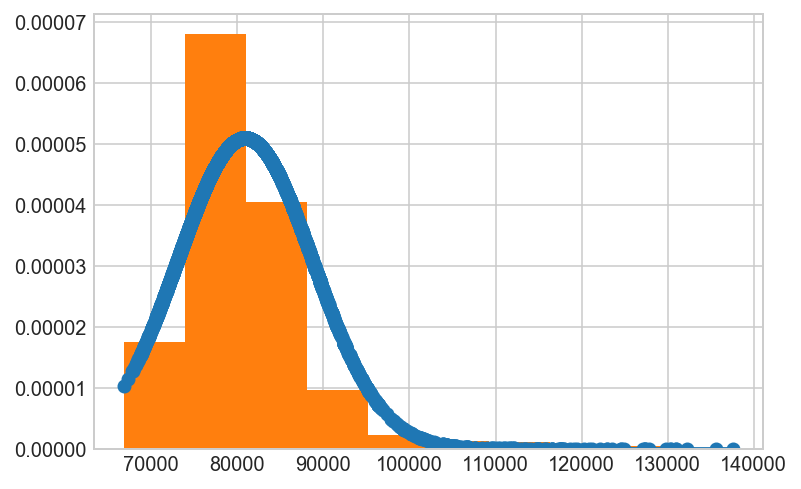

In [90]:
tc = sorted(test_data1['Total Cost'])  #sorted

fit = stats.norm.pdf(tc, np.mean(tc), np.std(tc))  #this is a fitting indeed

pl.plot(tc,fit,'-o')

pl.hist(tc,normed=True)      #use this to draw histogram of your data

pl.show()

In [91]:
test_data1['cost score']=[(((max(test_data1['Total Cost'])- x)/(max(test_data1['Total Cost'])-min(test_data1['Total Cost'])))*4)+1 for x in test_data1['Total Cost'] ]



In [92]:
test_df=pd.DataFrame({'cost score':test_data1['cost score'], 'boxcox' : scipy.stats.boxcox(test_data1['cost score'], lmbda=None, alpha=None)[0],
                     "Company Name + Variation Name":test_data1["Company Name + Variation Name"]})



In [93]:
test=pd.merge(test_data1,test_df,how='left',on=['Company Name + Variation Name','cost score']).drop_duplicates(subset=None, keep='first', inplace=False)


In [94]:
test_data2.columns

Index(['Company Name + Variation Name', 'total_score'], dtype='object')

In [95]:
test['cost score2']=[(((max(test['boxcox'])- x)/(max(test['boxcox'])-min(test['boxcox'])))*5) for x in test['boxcox'] ]





In [96]:
test_data=pd.merge(test,test_data2,on=['Company Name + Variation Name'],how='inner')

In [97]:
test_data.columns

Index(['collectiondate', 'isdiscontinued', 'uuid', 'variationuuid',
       'createdat', 'updatedat', 'productname', 'variationname',
       'gotositeenabled', 'gotositeurl',
       ...
       'Balance Outstanding', 'Total Repayment', 'Fees', 'Total Cost',
       'extrarepayments_value', 'Company Name + Variation Name', 'cost score',
       'boxcox', 'cost score2', 'total_score'],
      dtype='object', length=118)

In [98]:
test_data.shape

(4329, 118)

In [99]:
test_data=test_data[['extrarepaymentsallowed','allowssplitloan','hasoffsetaccount','hasredrawfacility',
                 'redrawactivationfee','hasfortnightlyrepayments','hasfulloffset','hasmonthlyrepayments',
                 'hasrepayholiday','hasweeklyrepayments','hasmortgageportability',
                 'hasprincipalandinterest','hasinterestonly','hasconstructionfacility','Company Name + Variation Name',
                 'portabilitytransferfee','extrarepayments_value','total_score','cost score2','Total Cost',
                     'cost score','boxcox'
          ]]

In [100]:
test_data=test_data.dropna(subset=['extrarepaymentsallowed','allowssplitloan','hasoffsetaccount','hasredrawfacility',
                 'redrawactivationfee','hasfortnightlyrepayments','hasfulloffset','hasmonthlyrepayments',
                 'hasrepayholiday','hasweeklyrepayments','hasmortgageportability',
                 'hasprincipalandinterest','hasinterestonly','hasconstructionfacility','Company Name + Variation Name',
                 'portabilitytransferfee','extrarepayments_value','total_score','cost score2', 'Total Cost'
          ])

In [101]:
test_data.portabilitytransferfee = test_data.portabilitytransferfee.replace([np.NaN,np.nan],0)

In [102]:
test_data.redrawactivationfee=test_data.redrawactivationfee.replace(np.nan, '', regex=True)
test_data['redrawactivationfee'] = pd.to_numeric(test_data['redrawactivationfee'], errors='coerce')
test_data['redrawactivationfee'] = np.nan_to_num(test_data['redrawactivationfee']).astype(float)

In [103]:
test_data['allowssplitloan'] =test_data['allowssplitloan'].astype(int)
test_data['hasfortnightlyrepayments'] =test_data['hasfortnightlyrepayments'].astype(int)
test_data['hasfulloffset'] =test_data['hasfulloffset'].astype(int)
test_data['hasmonthlyrepayments'] =test_data['hasmonthlyrepayments'].astype(int)
test_data['hasoffsetaccount'] =test_data['hasoffsetaccount'].astype(int)
test_data['hasrepayholiday'] =test_data['hasrepayholiday'].astype(int)
test_data['hasweeklyrepayments'] =test_data['hasweeklyrepayments'].astype(int)
test_data['hasmortgageportability'] =test_data['hasmortgageportability'].astype(int)
test_data['hasredrawfacility'] =test_data['hasredrawfacility'].astype(int)
test_data['hasprincipalandinterest'] =test_data['hasprincipalandinterest'].astype(int)
test_data['hasinterestonly'] =test_data['hasinterestonly'].astype(int)
test_data['hasconstructionfacility'] =test_data['hasconstructionfacility'].astype(int)
test_data['extrarepaymentsallowed'] =test_data['extrarepaymentsallowed'].astype(int)
test_data['portabilitytransferfee'] =test_data['portabilitytransferfee'].astype(int)
test_data['redrawactivationfee'] =test_data['redrawactivationfee'].astype(int)
test_data['extrarepayments_value'] =test_data['extrarepayments_value'].astype(int)

In [106]:
test_dummies=test_data[['extrarepaymentsallowed','allowssplitloan','hasoffsetaccount','hasredrawfacility',
                 'redrawactivationfee','hasfortnightlyrepayments','hasfulloffset','hasmonthlyrepayments',
                 'hasrepayholiday','hasweeklyrepayments','hasmortgageportability',
                 'hasprincipalandinterest','hasinterestonly','hasconstructionfacility','Company Name + Variation Name',
                 'portabilitytransferfee','total_score','extrarepayments_value','cost score2',
                       'Total Cost','cost score','boxcox']]

In [108]:
test_dummies.shape

(3243, 22)

In [109]:
X_test=test_dummies.drop(['Company Name + Variation Name','total_score','Total Cost','cost score','boxcox'],axis=1)

In [110]:
Xn_test = ss.fit_transform(X_test)

In [111]:
test_dummies['output_dtr']=rf.fit(X_train, y_train).predict(Xn_test)
# test_dummies['output_knn']=knnreg.predict(Xn_new_test)

In [112]:
test_dummies['Alogarithm']=round(test_dummies['output_dtr'],1)
test_dummies['Manual']=round(test_dummies['total_score'],1)
test_dummies['Difference']=test_dummies['Alogarithm']-test_dummies['Manual']

In [113]:
test_dummies.columns

Index(['extrarepaymentsallowed', 'allowssplitloan', 'hasoffsetaccount',
       'hasredrawfacility', 'redrawactivationfee', 'hasfortnightlyrepayments',
       'hasfulloffset', 'hasmonthlyrepayments', 'hasrepayholiday',
       'hasweeklyrepayments', 'hasmortgageportability',
       'hasprincipalandinterest', 'hasinterestonly', 'hasconstructionfacility',
       'Company Name + Variation Name', 'portabilitytransferfee',
       'total_score', 'extrarepayments_value', 'cost score2', 'Total Cost',
       'cost score', 'boxcox', 'output_dtr', 'Alogarithm', 'Manual',
       'Difference'],
      dtype='object')

In [114]:
test_dummies['Difference'].unique()

array([ 0. , -0.1, -0.1,  0.1,  0.2,  0.1,  0.1,  0.2, -0.1, -0.1,  0.2,
        0.3, -0.2,  0.7,  0.6, -0.2,  0.2,  0.1, -0.2, -0.2])

In [115]:
max(test_dummies['Difference'])

0.70000000000000018

In [116]:
min(test_dummies['Difference'])

-0.20000000000000018

In [117]:
len(test_dummies[test_dummies['Difference']==0.0])

2621

In [118]:
len(test_dummies['Difference'])

3243

In [119]:
test_accuracy=len(test_dummies[test_dummies['Difference']==0.0])/len(test_dummies['Difference']); 
test_accuracy*100

80.82022818378046

In [120]:
test_dummies=test_dummies[['extrarepaymentsallowed', 'allowssplitloan', 'hasoffsetaccount','hasredrawfacility', 
                           'redrawactivationfee', 'hasfortnightlyrepayments','hasfulloffset', 'hasmonthlyrepayments', 
                           'hasrepayholiday','hasweeklyrepayments', 'hasmortgageportability',
                           'hasprincipalandinterest', 'hasinterestonly','hasconstructionfacility',
                           'portabilitytransferfee', 'Company Name + Variation Name','Total Cost','cost score',
                           'boxcox','cost score2','output_dtr', 'total_score', 'Alogarithm', 'Manual','Difference']]

In [121]:
test_dummies.shape

(3243, 25)

In [122]:
test_dummies

,extrarepaymentsallowed,allowssplitloan,hasoffsetaccount,hasredrawfacility,redrawactivationfee,hasfortnightlyrepayments,hasfulloffset,hasmonthlyrepayments,hasrepayholiday,hasweeklyrepayments,...,Company Name + Variation Name,Total Cost,cost score,boxcox,cost score2,output_dtr,total_score,Alogarithm,Manual,Difference
0,1,1,0,1,0,1,0,1,0,1,...,Greater Bank - Ultimate Fixed Home Loan 4 Year...,73964.801473,4.597922,437.493569,1.725592,3.956047,3.959512,4.0,4.0,0.0
1,1,1,0,1,0,1,0,1,0,1,...,Greater Bank - Ultimate Fixed Home Loan 5 Year...,73700.844425,4.612850,444.713574,1.671554,4.013615,3.994064,4.0,4.0,0.0
2,1,1,1,1,0,1,0,1,0,1,...,Greater Bank - Ultimate Variable Home Loan (Ne...,71557.250552,4.734081,506.956359,1.205700,4.438910,4.474615,4.4,4.5,-0.1
3,1,1,0,1,0,1,0,1,0,1,...,Greater Bank - Great Rate Fixed Home Loan 1 Ye...,73775.439117,4.608631,442.663580,1.686898,3.959256,3.984299,4.0,4.0,0.0
4,1,1,0,1,0,1,0,1,0,1,...,Greater Bank - Great Rate Fixed Home Loan 3 Ye...,71928.853627,4.713065,495.694082,1.289992,4.196594,4.225981,4.2,4.2,0.0
5,1,1,0,1,0,1,0,1,0,1,...,Greater Bank - Great Rate Variable Home Loan (...,69682.250552,4.840122,566.954330,0.756647,4.596425,4.620015,4.6,4.6,0.0
6,1,1,0,1,0,1,0,1,1,1,...,Greater Bank - Ultimate Fixed Investment Loan ...,81237.878730,4.186591,272.531514,2.960246,3.057048,3.067617,3.1,3.1,0.0
7,1,1,0,1,0,1,0,1,1,1,...,Greater Bank - Ultimate Fixed Investment Loan ...,78205.327633,4.358098,333.798145,2.501698,3.455985,3.464517,3.5,3.5,0.0
8,1,1,0,1,0,1,0,1,1,1,...,Greater Bank - Ultimate Fixed Investment Loan ...,77351.925500,4.406362,352.891223,2.358796,3.564368,3.576209,3.6,3.6,0.0
9,1,1,0,1,0,1,0,1,1,1,...,Greater Bank - Ultimate Fixed Home Loan 4 Year...,75393.087416,4.517145,400.037064,2.005934,3.806333,3.832584,3.8,3.8,0.0


In [ ]:
test_dummies.to_csv('investigation_boxcox_total_rf_all.csv',index=None)